### Summary: 
- Task #1: [Visualize primary vs secondary needs](#primary_vs_secondary) 
  - Only used the 2022 interactions dataset since previous years don't have secondary needs data. 
  - Used headmap to visualize the number of times a secondary need is addressed on the same call as a given primary need. 
  - Primary needs are ordered based on the sum of the secondary needs count. Adjacent bar chart shows an 'impact' ranking, hopefully helpful to understand which primary need is associated with more secondary needs.   
  - The visualization is produced from loading the raw interactions dataset. I did not use a dataset already cleaned by other volunteers to make the code self contained. 
- Task #2: [Visualize primary vs taxonomy](#taxonomy_vs_primary) 
  - Used 2020, 2021 and 2022 interactions data
  - Also used a headmap for this visualization, but limited the taxonomies to the top ten. The ranking was based on the sum of primary needs related to a given taxonomy name. 
  - There are 300+ taxonomy names, displaying them all made the heatmap not very useful. Most taxonomy names have a score (total count of associated primary needs) of less than 50, while the top 3 taxonomies were above 1000 counts of associated primary needs. This also made scaling difficult. 
  - The visualization is produced from loading the raw interactions datasets. I did not use a dataset already cleaned by other volunteers to make the code self contained. 
  
### Next steps:
- Add visualizations to PowerBi or WebApp

### ETL task #1: Visualization of Primary vs Secondary needs

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval #dataset has list and dictionaries stored in columns as string,
                             #literal_eval converts them to python list/dict

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Only using 2022 data since previous years don't have secondary needs data. 
inter22 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2022.csv')

In [3]:
#Shorten the name of the Primary and Secondary needs columns
inter22 = inter22.rename(columns={'InteractionOption_SwfPrimaryNeeds': 'Primary',
                        'InteractionOption_SwfSecondaryNeeds': 'Secondary'})

In [4]:
#Most Secondary needs rows are empty or are caller declined. Hopefully overtime there will be more Secondary need data to visualize. 
inter22['Secondary'].value_counts()

[]                                                                   7100
['Caller declined']                                                   270
['Warm Transferred']                                                    9
['Housing Payment Assistance']                                          5
['Food']                                                                4
['Other']                                                               3
['Mental Health', 'Other Financial Assistance']                         1
['Shelter']                                                             1
['Food', 'Other Financial Assistance']                                  1
['Shelter', 'Transportation']                                           1
['Housing Payment Assistance', 'Legal Assistance', 'Other']             1
['Utility/Energy', 'Other Financial Assistance']                        1
['Food', 'Transportation']                                              1
['Food', 'Utility/Energy', 'Housing Pa

In [5]:
df = (inter22
    .assign(Primary=inter22.Primary.apply(lambda x: literal_eval(x)), #Convert string literal to list. 
            Secondary=inter22.Secondary.apply(lambda x: literal_eval(x)) #Convert string literal to list. 
           )
    .explode('Primary') #Place each list item in a row. Some primary entries where list of len > 1 - e.g. ['Food', 'Crisis'] 
    .explode('Secondary') #Same as with primary, place each list item on a separate row. 
    [['Primary', 'Secondary']]
    .query('Secondary!="Caller declined"') #Remove rows with caller declined entries
    .dropna() 
    .groupby(['Primary','Secondary'])['Secondary'] 
    .count() #Count the number of times a primary needs triggers a given secondary need
    .reset_index(name='ct') #add count to new column name 'ct'
    .pivot_table(index='Primary', columns='Secondary', values='ct') #create pivot table to easily produce heatmap from it
    .fillna(0)
    )
df

Secondary,Food,Housing Payment Assistance,Legal Assistance,Mental Health,Other,Other Financial Assistance,Shelter,Transportation,Utility/Energy,Warm Transferred
Primary,,,,,,,,,,
Crisis,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Food,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
Housing Payment Assistance,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Legal Assistance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Mental Health,1.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,4.0
Other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
Other Financial Assistance,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Shelter,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
Supportive Listening,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
#We thought it would be good to sort primary needs based on the total number of secondary needs it triggers
#Create a score column named 'impact_on_secondary' to use as sorting criteria
df = (df
     .assign(impact_on_secondary=df.sum(axis=1)) 
     .sort_values(by='impact_on_secondary', ascending=False)
     )
df.head()

Secondary,Food,Housing Payment Assistance,Legal Assistance,Mental Health,Other,Other Financial Assistance,Shelter,Transportation,Utility/Energy,Warm Transferred,impact_on_secondary
Primary,,,,,,,,,,,
Mental Health,1.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,4.0,13.0
Food,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
Shelter,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,6.0
Crisis,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
Other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,5.0


### Output task #1: Visualization of Primary vs Secondary needs
<a id='primary_vs_secondary'></a>

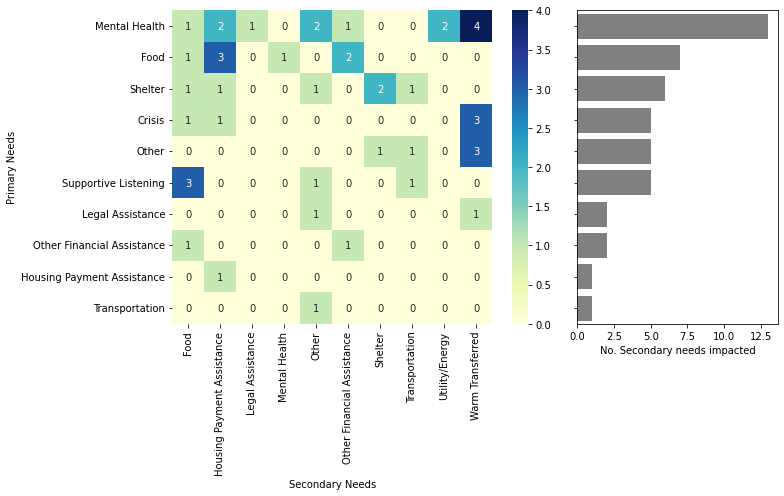

In [7]:
fig, axes = plt.subplots(1,2, figsize=(11, 7), gridspec_kw={'width_ratios': [2, 1]})

heat = sns.heatmap(df.drop('impact_on_secondary', axis=1), 
                   annot=True, 
                   cmap="YlGnBu", 
                   #cbar=False, 
                   ax=axes[0])
_ = heat.set(xlabel='Secondary Needs')
_ = heat.set(ylabel='Primary Needs')

bar = sns.barplot(x=df.impact_on_secondary, 
            y=df.index, 
            color='gray',
            ax=axes[1])
_ = bar.set(yticklabels=[])
_ = bar.set(ylabel=None)
_ = bar.set(xlabel='No. Secondary needs impacted')

fig.tight_layout()

## ETL task #2: Taxonomy vs Primary needs visualization

In [8]:
#Loading the data again in case this visualization is run independently of the previous one
#Using 2020, 2021 and 2022 interactions datasets
inter20 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2020.csv')
inter21 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2021.csv')
inter22 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2022.csv')

In [9]:
cols = ['InteractionOption_SwfPrimaryNeeds', 
        'InteractionReferral_ReferralsModule']

In [10]:
#Select only columns of interest for efficiency
taxonomy = (pd.concat([inter20[cols], inter21[cols], inter22[cols]])
        .dropna()
        )

In [11]:
#Create a dataframe with taxonomy name as index and primary needs as columns. Values are the number of times a 
#call with a given taxonomy name had a given primary need 
taxonomy = (taxonomy
        #Convert string literal to list. Primary needs are lists saved as strings
        .assign(Primary=taxonomy.InteractionOption_SwfPrimaryNeeds.apply(lambda x: literal_eval(x)), 
                #Parse the taxonomy name
                taxonomy_name=(taxonomy
                               .InteractionReferral_ReferralsModule
                               .str.split("'Taxonomy_Name':")
                               .apply(lambda x: x[1])
                               .str.split(',')
                               .apply(lambda x: x[0])
                               .str.strip().str.replace("'", "")
                              )
                )
        .explode('Primary') #Place each list item in a row. Some primary entries where list of len > 1 - e.g. ['Food', 'Crisis'] 
        [['Primary', 'taxonomy_name']]
        .dropna()
        .groupby(['taxonomy_name','Primary'])['Primary']
        .count()#Count the number of times a taxonomy name is in a call with a given primary need
        .reset_index(name='ct')
        .pivot_table(index='taxonomy_name', columns='Primary', values='ct')#Pivot table to easily display it as a heatmap
        .fillna(0)
        )

In [12]:
#We thought it would be good to sort taxonomy names based on the total number of primary needs it is associated with
#Create a score column named 'impact_on_primary' to use as sorting criteria
taxonomy = (taxonomy
            .assign(impact_on_primary=taxonomy.sum(axis=1))
            .sort_values(by='impact_on_primary', ascending=False)
            )

### Visualization: Taxonomy name vs Primary needs heat map

In [13]:
#There are over 300 taxonomy names
taxonomy.index

Index(['Talklines/Warmlines', 'Food Pantries', 'Community Shelters',
       'Housing Related Coordinated Entry',
       'Electric Service Payment Assistance',
       'Low Income/Subsidized Private Rental Housing',
       'Rent Payment Assistance', 'General Crisis Intervention Hotlines',
       'Directory Assistance', 'Mental Health Crisis Lines',
       ...
       '"Renters Tax Credit Information"', 'Housing Down Payment Loans/Grants',
       'In Home Attendants for People With Disabilities',
       'Independent Living Communities/Complexes',
       'Independent Living Skills Instruction', 'Individual Advocacy',
       'Individual Taxpayer Identification Numbers',
       'Indoor Air Pollution Information',
       'Inpatient Drug Use Disorder Treatment Facilities', 'Youth Shelters'],
      dtype='object', name='taxonomy_name', length=371)

In [14]:
#Select top 10 taxonomy names only. Displaying all makes the heatmap not informative. 
taxonomy = taxonomy.head(10)

In [15]:
taxonomy

Primary,Crisis,Directory Assistance,Food,Health Care Coverage,Housing Payment Assistance,Legal Assistance,Mental Health,Other,Other Financial Assistance,Shelter,Substance Use,Supportive Listening,Transportation,Utility/Energy,impact_on_primary
taxonomy_name,,,,,,,,,,,,,,,
Talklines/Warmlines,32.0,5.0,1.0,0.0,2.0,1.0,403.0,26.0,1.0,8.0,0.0,2006.0,0.0,0.0,2485.0
Food Pantries,0.0,0.0,437.0,0.0,4.0,0.0,0.0,29.0,0.0,4.0,0.0,1.0,1.0,1.0,477.0
Community Shelters,0.0,1.0,2.0,0.0,8.0,0.0,3.0,37.0,0.0,325.0,0.0,0.0,3.0,0.0,379.0
Housing Related Coordinated Entry,0.0,0.0,1.0,0.0,23.0,1.0,2.0,17.0,0.0,274.0,0.0,0.0,0.0,2.0,320.0
Electric Service Payment Assistance,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,282.0,290.0
Low Income/Subsidized Private Rental Housing,0.0,2.0,1.0,0.0,45.0,0.0,0.0,38.0,0.0,28.0,0.0,0.0,0.0,1.0,115.0
Rent Payment Assistance,2.0,1.0,2.0,0.0,79.0,0.0,2.0,13.0,1.0,6.0,0.0,0.0,0.0,6.0,112.0
General Crisis Intervention Hotlines,44.0,1.0,0.0,0.0,0.0,0.0,38.0,16.0,0.0,1.0,0.0,7.0,0.0,0.0,107.0
Directory Assistance,0.0,84.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,1.0,0.0,98.0


### Output task #2: Taxonomy names vs primary needs visualization
<a id='taxonomy_vs_primary'></a>

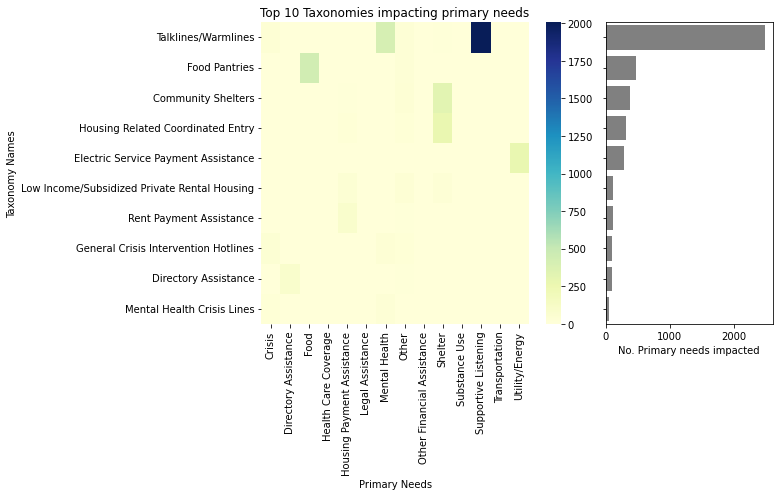

In [16]:
fig, axes = plt.subplots(1,2, figsize=(11, 7), gridspec_kw={'width_ratios': [2, 1]})

heatmap_taxonomy = sns.heatmap(taxonomy.drop('impact_on_primary', axis=1),
               #annot=True,
               cmap="YlGnBu",
               ax=axes[0]
               )
_ = heatmap_taxonomy.set(ylabel='Taxonomy Names')
_ = heatmap_taxonomy.set(xlabel='Primary Needs')
_ = heatmap_taxonomy.set(title='Top 10 Taxonomies impacting primary needs')

bar_taxonomy = sns.barplot(x=taxonomy.impact_on_primary, 
            y=taxonomy.index, 
            color='gray',
            ax=axes[1]
            )

_ = bar_taxonomy.set(yticklabels=[])
_ = bar_taxonomy.set(ylabel=None)
_ = bar_taxonomy.set(xlabel='No. Primary needs impacted')

fig.tight_layout()